### plot_simulator_inputs

This notebook gives visualizations of some of the inputs to the simulator.

In [1]:
# hack to get the path right
import sys
sys.path.append('..')

In [2]:
import ztf_sim
from astropy.time import Time
import pandas as pd
import numpy as np
import astropy.units as u
import pylab as plt
import seaborn as sns
%matplotlib inline

/Users/ebellm/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
sns.set_style('ticks')
sns.set_context('talk')

### weather

We have binned PTF observing into 20 minute intervals to use as a proxy for weather, daylight, and other downtime.

In [4]:
df = ztf_sim.utils.df_read_from_sqlite('weather_blocks')

In [5]:
df.head()

,year,block,nexps
0,2009,1089,9
1,2009,1090,11
2,2009,1091,3
3,2009,1092,6
4,2009,1095,2


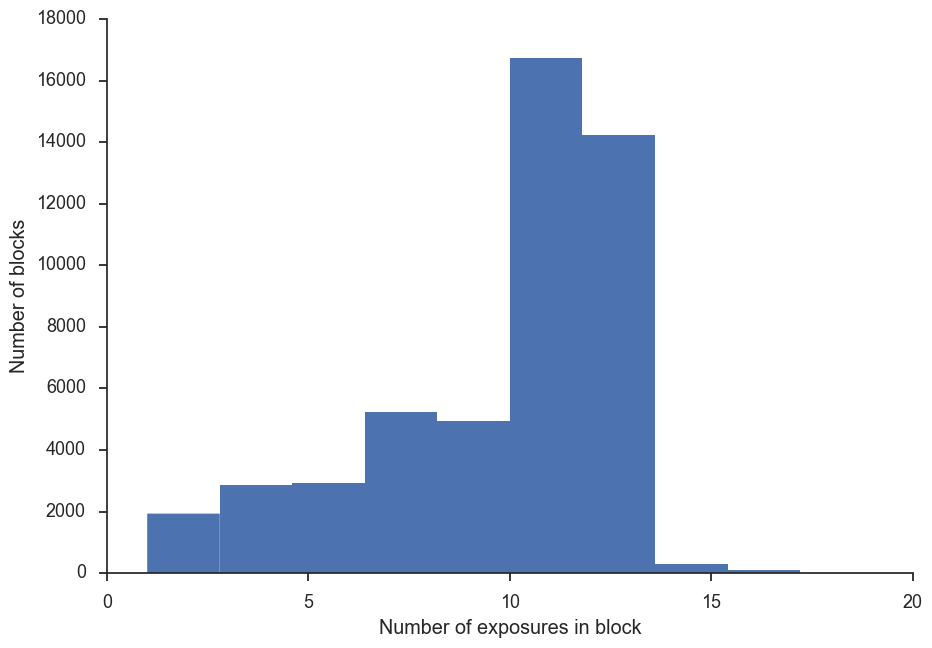

In [6]:
plt.hist(df['nexps'])
plt.xlabel('Number of exposures in block')
plt.ylabel('Number of blocks')
sns.despine()

We see a peak near 12 images per block, which at ~100 seconds average time per exposure matches our 20 minute block size:

In [7]:
12*100*u.second.to(u.min)

20.0

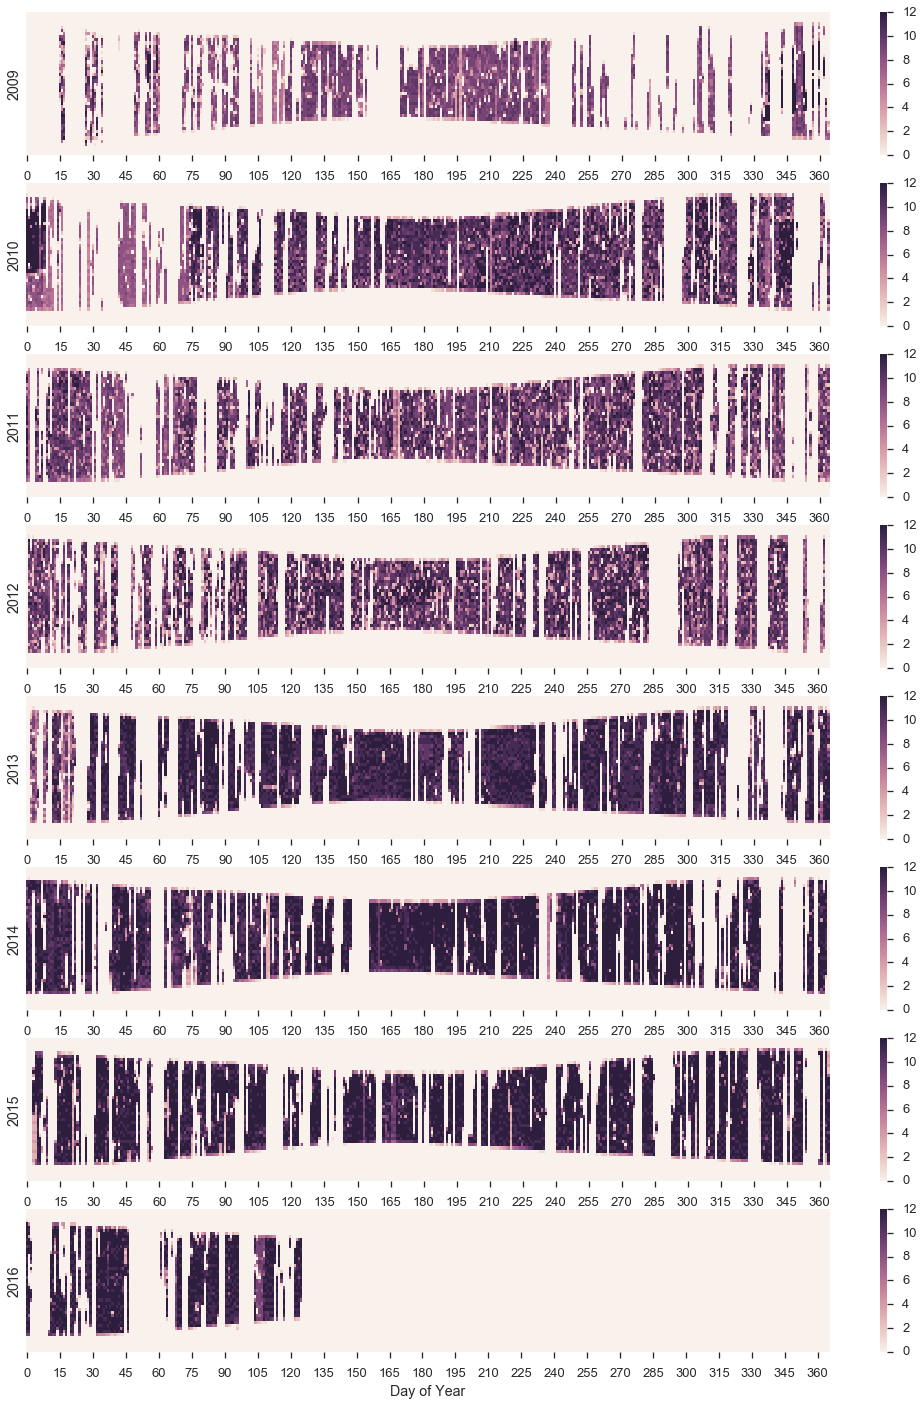

In [11]:
blocks_per_day = np.round((1.*u.day).to(u.min)/ztf_sim.constants.TIME_BLOCK_SIZE).astype(np.int)
fig = plt.figure(figsize=(18,24))
# cut off 2016, which is partial
#df = df[df['year'] < 2016]
years = np.sort(list(set(df['year'])))
nyears = len(years)
for i, year in enumerate(years):
    ax = plt.subplot(nyears,1,i+1)
    w = df['year'] == year
    # make an array to hold these, including zeros for times without observations

    # buggy but sufficient accounting for leap years
    ndays = 365
    if year % 4 == 0:
        ndays += 1
    nexps = np.zeros([ndays,blocks_per_day])
    for block, n in zip(df[w]['block'],df[w]['nexps']):
        nexps.flat[block] = n
    sns.heatmap(nexps.T,xticklabels=15,yticklabels=False,vmin=0,vmax=12)
    ax.set_ylim([25,70]) # this was guess and check...
    ax.set_ylabel(np.int(year))
ax.set_xlabel('Day of Year')
plt.savefig('fig/PTF_exposure_blocks.png',bbox_inches='tight')

Let's look at the raw image times (all filters, including H-alpha) to understand the available observing time.

In [61]:
df = pd.read_table('../data/mjd.txt.gz', sep='|',
                       names=['expMJD'],
                       skipfooter=1)
# let's just look at complete iPTF years
df = df[(df['expMJD'] >= Time('2013-01-01').mjd) & (df['expMJD'] < Time('2016-01-01').mjd)]
t = Time(df['expMJD'], format='mjd', location=ztf_sim.utils.P48_loc)
df['datetime'] = t.datetime
df = df.set_index('datetime')
df['month'] = df.index.month
#df['day'] = df.index.day
df['night'] = np.floor(t.mjd).astype(np.int)
#df['night'] = t.iso
#df['night'] = df['night'].apply(lambda x: x.split(' ')[0])
#df['year'] = np.floor(t.decimalyear).astype(np.int)
# these are slow, but faster than me figuring out how to speed them up
#df['month'] = [ti.datetime.month for ti in t]
#df['day'] = [ti.datetime.day for ti in t]

/Users/ebellm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


Now count exposures by night

In [65]:
grp = df.groupby(['night'])
nexps = grp['expMJD'].agg(len)
nexps.name = 'nexps'
# make a month dataframe
dfm = grp.agg(lambda x:x)
df = df.join(nexps,on='night')

ValueError: cannot copy sequence with size 5 to array axis with dimension 191

Convert to observing time in hours using our average time between exposures.  This means our observing time estimate is conservative, because it excludes long slews.

In [63]:
df['obstime'] = df['nexps'] * 100./3600.

In [64]:
df.head()

,expMJD,month,night,nexps,obstime
datetime,,,,,
2013-01-03 02:07:40.224,56295.08866,1,56295,191.0,5.305556
2013-01-03 02:35:49.344,56295.10821,1,56295,191.0,5.305556
2013-01-03 02:38:37.824,56295.11016,1,56295,191.0,5.305556
2013-01-03 02:40:18.048,56295.11132,1,56295,191.0,5.305556
2013-01-03 02:58:32.736,56295.12399,1,56295,191.0,5.305556


Aggregate by month:

In [ ]:
grp = df.groupby('month')


In [53]:
# now fill missing dates with zeros--nights with no exposures due to weather or
# other downtime
# (df.asfreq('D') doesn't let me set the fill value)
df = df.reindex(pandas.date_range(df.index.min(),df.index.max()),fill_value=0)

,expMJD,month
datetime,,
2013-01-03 02:07:40.224,56295.08866,1
2013-01-03 02:35:49.344,56295.10821,1
2013-01-03 02:38:37.824,56295.11016,1
2013-01-03 02:40:18.048,56295.11132,1
2013-01-03 02:58:32.736,56295.12399,1


In [42]:
pd.date_range('2013-01-01','2015-12-31')

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', length=1095, freq='D')